In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of skaro, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yt
from matplotlib.ticker import FuncFormatter

from skaro.analysis import bin_planets
from skaro.model import Model
from skaro.utilities.dataframe import aggregated_dataframe, rename_labels
from skaro.utilities.math import calculate_pca
from skaro.visualization.seaborn_extensions import logyregplot
from skaro.visualization.visualization_utils import (
    FigureProcessor,
    adjust_legend,
    get_palette,
    ridgeplot,
    set_plot_defaults,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting sim_id to 09_18.



yt : [INFO     ] 2024-03-11 10:08:02,443 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2024-03-11 10:08:02,503 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2024-03-11 10:08:02,504 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-03-11 10:08:02,504 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-03-11 10:08:02,505 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2024-03-11 10:08:02,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-03-11 10:08:02,506 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2024-03-11 10:08:02,506 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2024-03-11 10:08:02,506 Parameters: omega_matter              = 0.318
yt : [INFO     ] 2024-03-11 10:08:02,507 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-03-11 10:08:02,508 Parameters: hubble_constant   

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Radial_planet_distribution"
save = True

## CREATE DATASOURCE

In [7]:
radius = 0.2 * mw.virial_radius()

## NORMALISED PROFILES

In [21]:
normalized_profiles, bins = bin_planets(
    model,
    lambda: mw.sphere(radius=radius),
    ["total_number"] + planet_categories,
    bin_field="particle_radius",
    model_config={"ngpps_num_embryos": 50},
    num_bins=200,
    bin_limits=(1, 25),
    log_bins=True,
    density="spherical",
    normalize="first_bin",
    cumulative=False,
    long_format=True,
    value_name="Normalized Density of Planets",
    description={"num_embryos": num_embryos},
)
normalized_profiles, normalized_profiles_label_dict = rename_labels(normalized_profiles)


      TIMER: Block 'Adding Planets...' took 1.31 seconds.



In [19]:
planet_categories

['Earth', 'Super-Earth', 'Neptunian', 'Sub-Giant', 'Giant']

In [18]:
mw.sphere(radius=radius)["galaxy_stars", "total_number"]

unyt_array([454694.78285035, 326265.47770783, 366394.53088514, ...,
            511880.86148102, 212282.77957919, 605644.28183799], 'dimensionless')

In [27]:
normalized_profiles

,Distance (kpc),Planet Type,Normalized Density of Planets,num_embryos
0,1.008112,total_number,1.000000,50
1,1.024469,total_number,0.928135,50
2,1.041090,total_number,0.894299,50
3,1.057981,total_number,0.897637,50
4,1.075147,total_number,0.860885,50
...,...,...,...,...
1195,23.254147,Giant,0.000011,50
1196,23.631436,Giant,0.000010,50
1197,24.014847,Giant,0.000009,50
1198,24.404478,Giant,0.000008,50


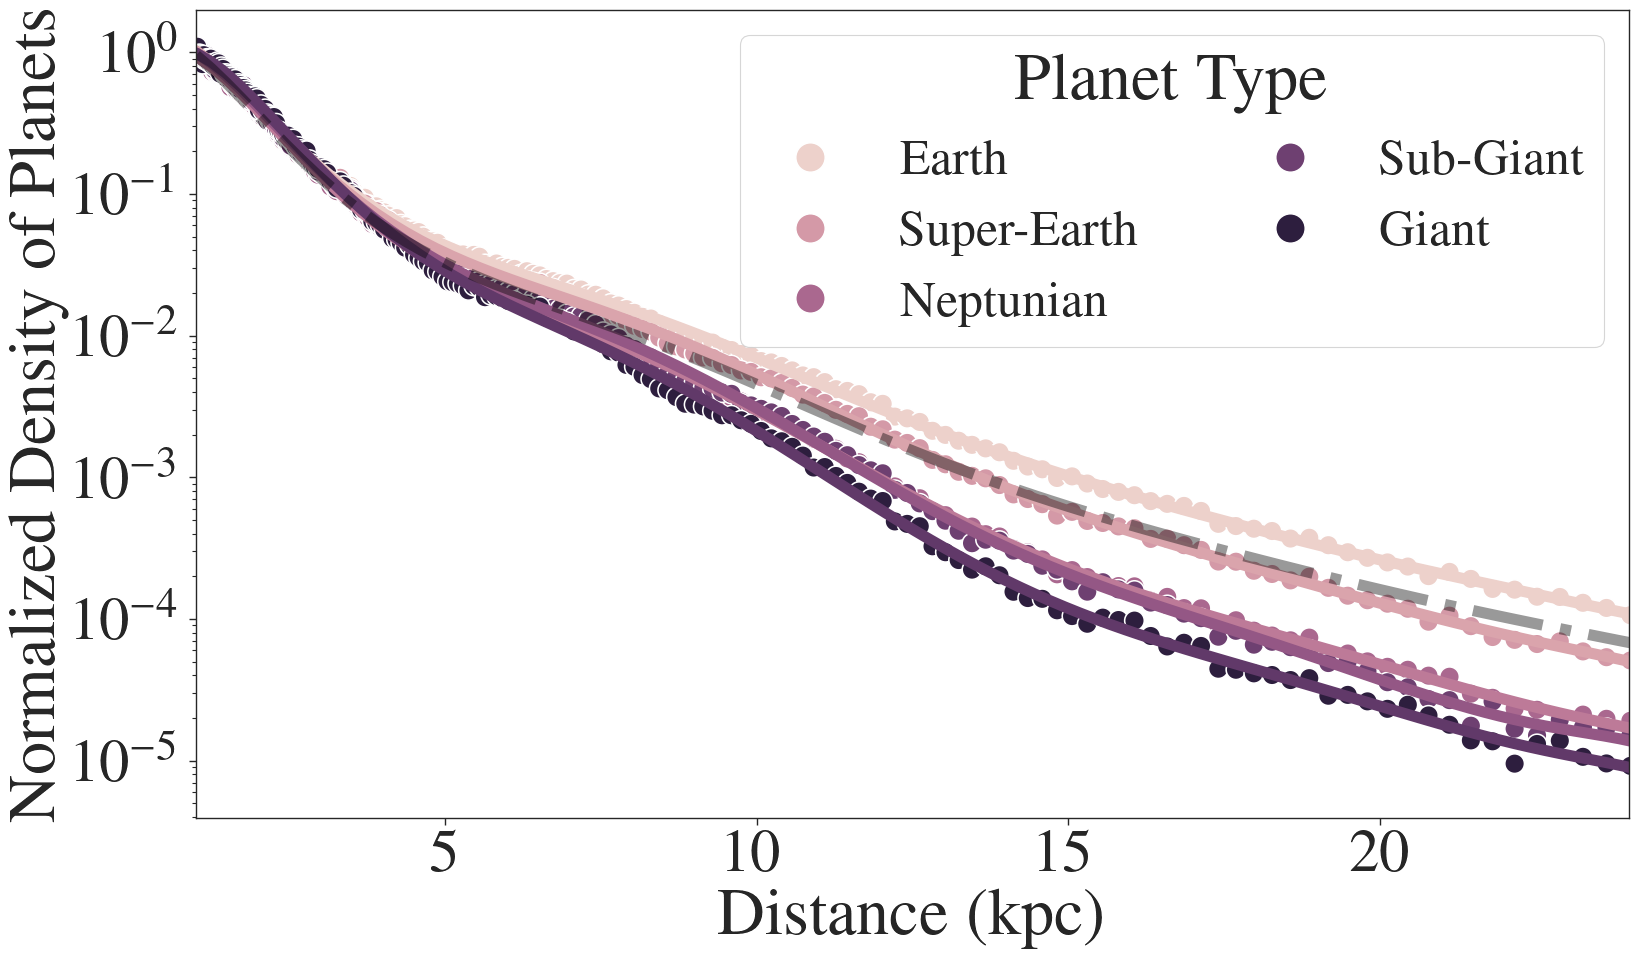

In [47]:
with sns.axes_style("ticks"):
    fig, normalized_plot = plt.subplots()
    for i, planet_type in enumerate(planet_categories):
        logyregplot(
            normalized_profiles[normalized_profiles["Planet Type"] == planet_type],
            x=normalized_profiles_label_dict["particle_radius"],
            y="Normalized Density of Planets",
            color=get_palette()[i],
            scatter=False,
            ci=None,
            line_kws={"linewidth": 8},
            scatter_kws={"s": 0},
            order=9,
            ax=normalized_plot,
        )
    sns.scatterplot(
        normalized_profiles[normalized_profiles["Planet Type"] != "total_number"],
        x=normalized_profiles_label_dict["particle_radius"],
        y="Normalized Density of Planets",
        hue="Planet Type",
        palette=get_palette(n_colors=len(planet_categories)),
        s=200,
        ax=normalized_plot,
    )

    # add total number of stars using logyregplot
    logyregplot(
        normalized_profiles[normalized_profiles["Planet Type"] == "total_number"],
        x=normalized_profiles_label_dict["particle_radius"],
        y="Normalized Density of Planets",
        color="black",
        scatter=False,
        ci=None,
        line_kws={"linewidth": 8, "alpha": 0.4, "linestyle": "-."},
        scatter_kws={"s": 0},
        order=9,
        ax=normalized_plot,
    )

    normalized_plot.set_xlim(1, 24)
    normalized_plot.legend(
        markerscale=1.5, title="Planet Type", prop={"size": 36}, ncol=2
    )
    normalized_plot.set_yscale("log")

FigureProcessor(normalized_plot.figure).save(
    f"normalized_planet_density.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## CUMULATIVE PROFILES

In [11]:
cumulative_profiles, bins = bin_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    bin_field="particle_radius",
    model_config={"ngpps_num_embryos": 50},
    num_bins=200,
    bin_limits=(0.001, 10),
    log_bins=True,
    density=None,
    normalize="area",
    cumulative=True,
    long_format=True,
    value_name="Cumulative Fraction of Planets",
    description={"num_embryos": num_embryos},
)
cumulative_profiles, cumulative_profiles_label_dict = rename_labels(cumulative_profiles)


      TIMER: Block 'Adding Planets...' took 1.58 seconds.



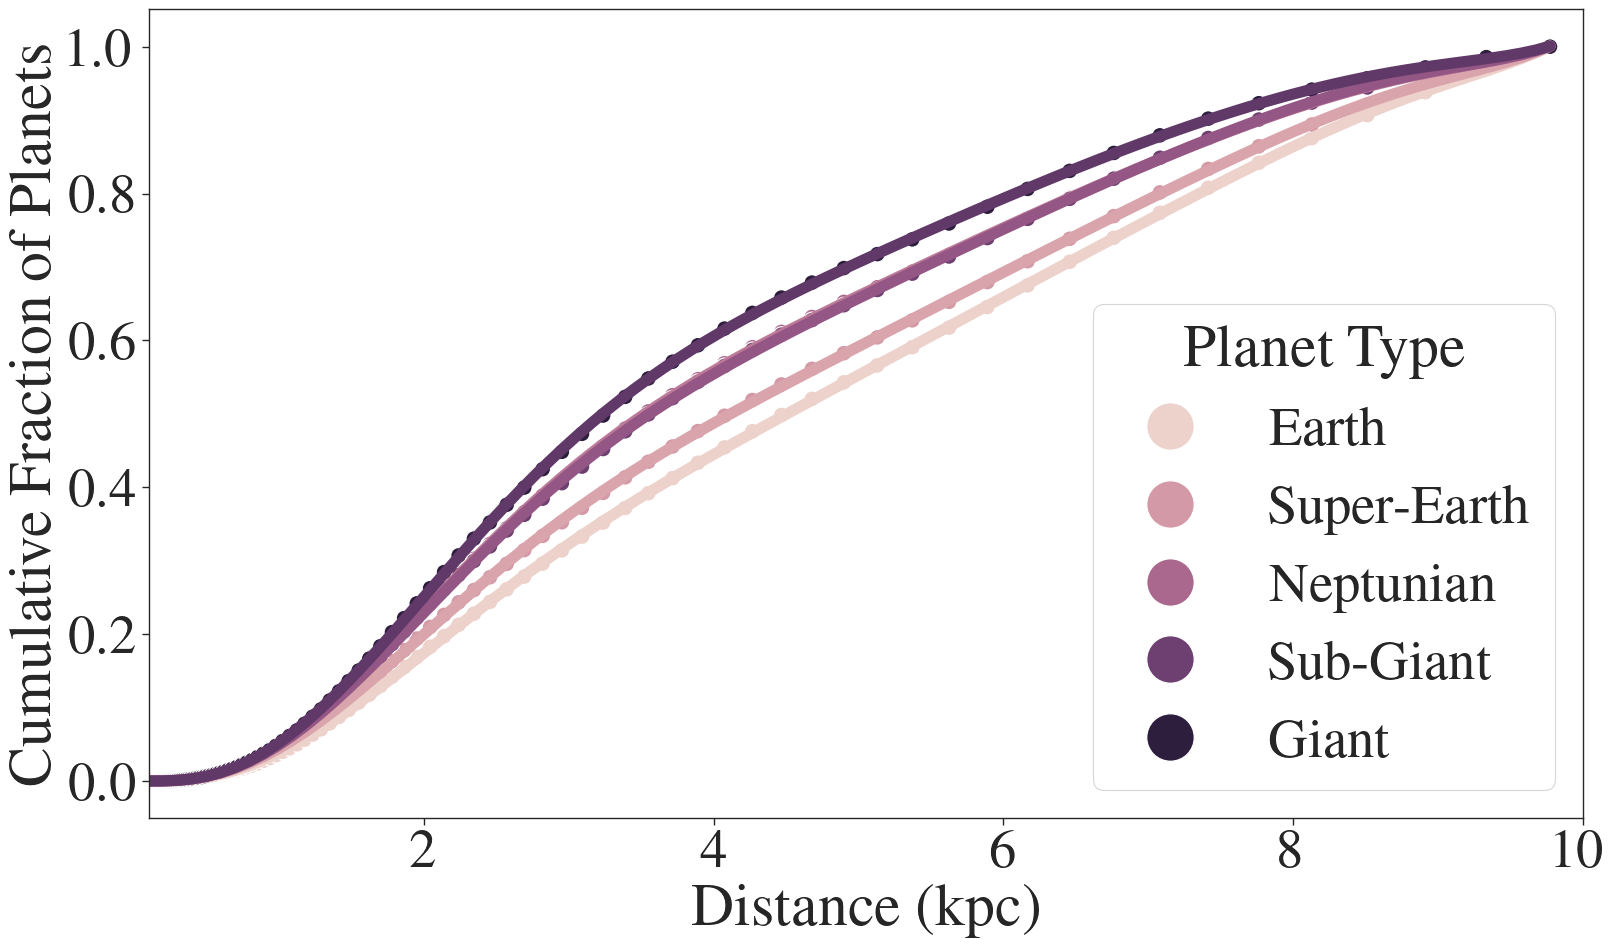

In [12]:
with sns.axes_style("ticks"):
    fig, cumulative_plot = plt.subplots()
    for i, planet_type in enumerate(planet_categories):
        sns.regplot(
            cumulative_profiles[cumulative_profiles["Planet Type"] == planet_type],
            x=cumulative_profiles_label_dict["particle_radius"],
            y="Cumulative Fraction of Planets",
            color=get_palette()[i],
            scatter=False,
            ci=None,
            line_kws={"linewidth": 8},
            order=9,
            ax=cumulative_plot,
        )
    sns.scatterplot(
        cumulative_profiles,
        x=cumulative_profiles_label_dict["particle_radius"],
        y="Cumulative Fraction of Planets",
        hue="Planet Type",
        palette=get_palette(n_colors=len(planet_categories)),
        s=20,
        ax=cumulative_plot,
    )

    cumulative_plot.set_xlim(0.1, 10)
    cumulative_plot.legend(markerscale=3, title="Planet Type")

FigureProcessor(cumulative_plot.figure).save(
    f"cumulative_planet_distribution.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)

## EMBRYO NUMBER EFFECT

In [13]:
planet_profiles = []
for num_embryos in [10, 20, 50, 100]:
    profiles, bins = bin_planets(
        model,
        lambda: mw.sphere(radius=radius),
        planet_categories,
        bin_field="particle_radius",
        model_config={"ngpps_num_embryos": num_embryos},
        num_bins=30,
        bin_limits=(1, 25),
        log_bins=True,
        density="spherical",
        long_format=True,
        value_name=r"Density of Planets (1/kpc$^3$)",
        description={"num_embryos": num_embryos},
    )
    planet_profiles.append(profiles)
planet_profiles = pd.concat(planet_profiles)
planet_profiles, planet_profiles_label_dict = rename_labels(planet_profiles)


      CONFIG: Setting ngpps_num_embryos to 10.




      TIMER: Block 'Adding Planets...' took 1.13 seconds.


      CONFIG: Setting ngpps_num_embryos to 20.


      TIMER: Block 'Adding Planets...' took 1.17 seconds.


      CONFIG: Setting ngpps_num_embryos to 50.


      TIMER: Block 'Adding Planets...' took 1.49 seconds.


      CONFIG: Setting ngpps_num_embryos to 100.


      TIMER: Block 'Adding Planets...' took 2.1 seconds.



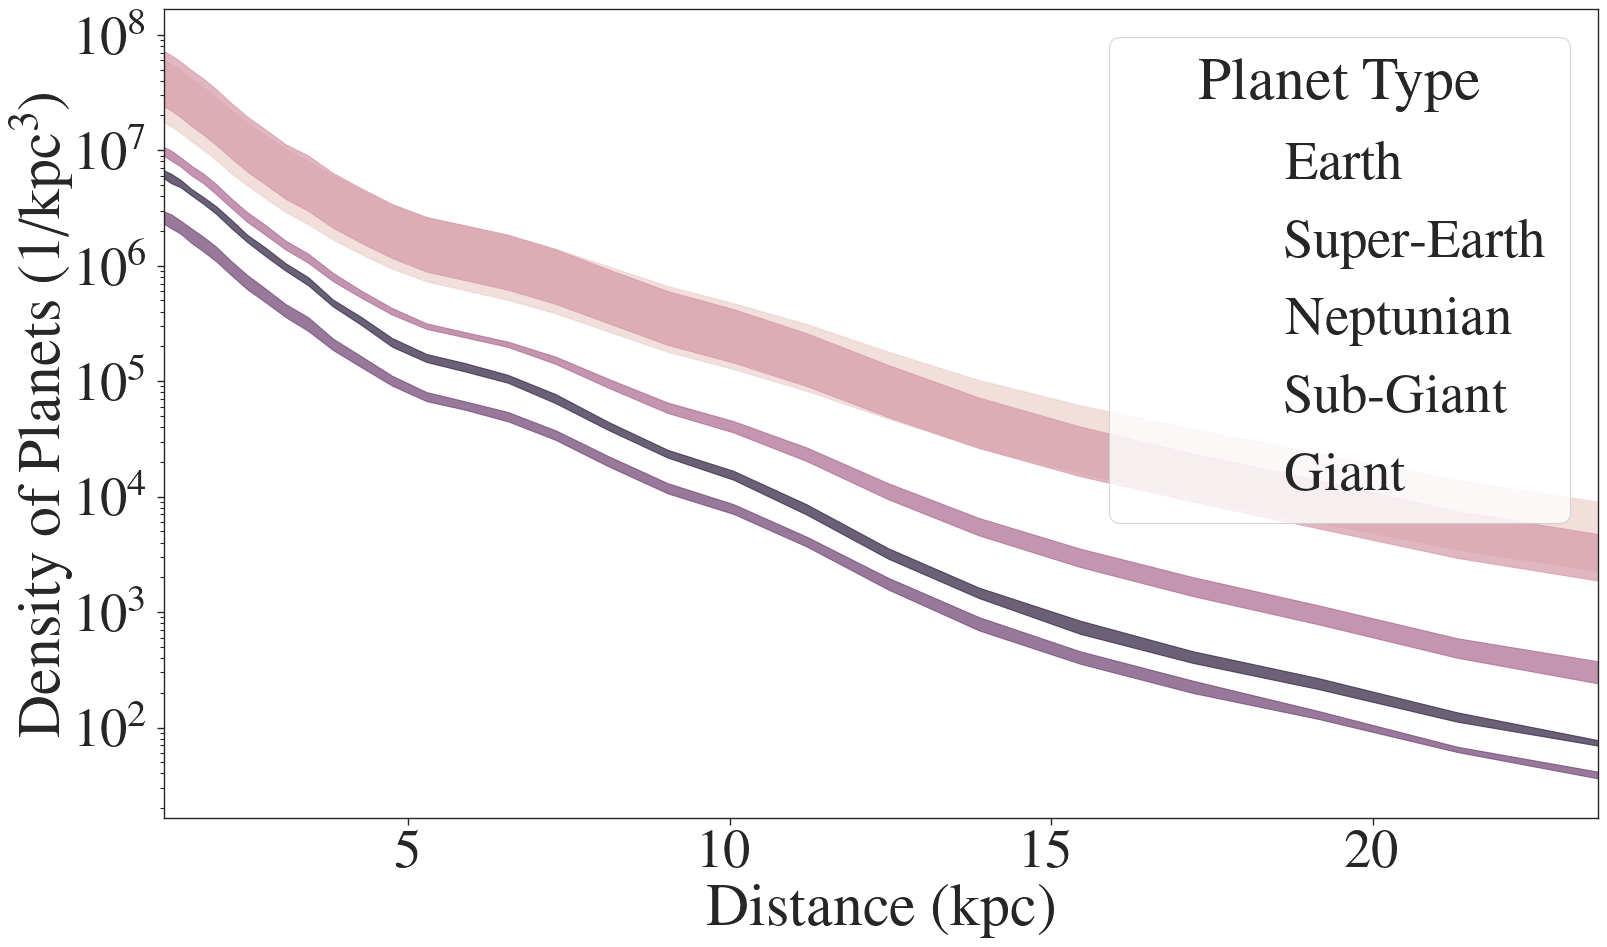

In [14]:
with sns.axes_style("ticks"):
    profile_plot = sns.lineplot(
        planet_profiles,
        x=planet_profiles_label_dict["particle_radius"],
        y="Density of Planets (1/kpc$^3$)",
        hue="Planet Type",
        errorbar=("pi", 100),
        palette=get_palette(n_colors=len(planet_categories)),
        alpha=0,
        err_kws={"alpha": 0.7},
    )
    profile_plot.set_xlim(1.2, 23.5)
    profile_plot.set_yscale("log")

FigureProcessor(cumulative_plot.figure).save(
    f"radial_planet_density.pdf",
    sub_directory=figure_subdirectory,
    save=save,
)